# Numpy backup for scaling in the beginning

In [1]:
import numpy as np
from pdg_const import pdg
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import sys
import time
from helperfunctions import display_time, prepare_plot
import cmath as c
import scipy.integrate as integrate
from scipy.optimize import fminbound
from array import array as arr
import collections
from itertools import compress
import tensorflow as tf
import zfit
from zfit import ztf
from IPython.display import clear_output
import os

c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\util\execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
def formfactor( q2, subscript): #returns real value
    #check if subscript is viable

    if subscript != "0" and subscript != "+" and subscript != "T":
        raise ValueError('Wrong subscript entered, choose either 0, + or T')

    #get constants

    mK = pdg['Ks_M']
    mbstar0 = pdg["mbstar0"]
    mbstar = pdg["mbstar"]
    b0 = pdg["b0"]
    bplus = pdg["bplus"]
    bT = pdg["bT"]

    mmu = pdg['muon_M']
    mb = pdg['bquark_M']
    ms = pdg['squark_M']
    mB = pdg['Bplus_M']

    #N comes from derivation in paper

    N = 3

    #some helperfunctions

    tpos = (mB - mK)**2
    tzero = (mB + mK)*(np.sqrt(mB)-np.sqrt(mK))**2

    z_oben = np.sqrt(tpos - q2) - np.sqrt(tpos - tzero)
    z_unten = np.sqrt(tpos - q2) + np.sqrt(tpos - tzero)
    z = z_oben/ z_unten

    #calculate f0

    if subscript == "0":
        prefactor = 1/(1 - q2/(mbstar0**2))
        _sum = 0

        for i in range(N):
            _sum += b0[i]*(np.power(z,i))

        return prefactor * _sum

    #calculate f+ or fT

    else:
        prefactor = 1/(1 - q2/(mbstar**2))
        _sum = 0

        if subscript == "T":
            b = bT
        else:
            b = bplus

        for i in range(N):
            _sum += b[i] * (np.power(z, i) - ((-1)**(i-N)) * (i/N) * np.power(z, N))

        return prefactor * _sum

def resonance(q, _mass, width, phase, scale):

    q2 = np.power(q, 2)

    mmu = pdg['muon_M']

    p = 0.5 * np.sqrt(q2 - 4*(mmu**2))

    p0 =  0.5 * np.sqrt(_mass**2 - 4*mmu**2)

    gamma_j = p/ q2 * _mass * width / p0

    #Calculate the resonance

    _top = _mass * width

    _bottom = np.vectorize(complex)(_mass**2 - q2, -_mass*gamma_j)

    com = _top/_bottom

    #Rotate by the phase

    r = scale*np.abs(com)

    _phase = np.angle(com)

    _phase += phase

    com = r * np.exp(np.vectorize(complex)(0.0 , _phase))

    return com


def axiv_nonres(q):

    GF = pdg['GF']
    alpha_ew = pdg['alpha_ew']
    Vtb = pdg['Vtb']
    Vts = pdg['Vts']
    C10eff = pdg['C10eff']

    mmu = pdg['muon_M']
    mb = pdg['bquark_M']
    ms = pdg['squark_M']
    mK = pdg['Ks_M']
    mB = pdg['Bplus_M']

    q2 = np.power(q, 2)

    #Some helperfunctions

    beta = np.sqrt(np.abs(1. - 4. * mmu**2. / q2))

    kabs = np.sqrt(mB**2. +np.power(q2, 2)/mB**2. + mK**4./mB**2. - 2. * (mB**2. * mK**2. + mK**2. * q2 + mB**2. * q2) / mB**2.)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (np.abs(Vtb*Vts))**2. * kabs * beta / (128. * np.pi**5.)

    #left term in bracket

    bracket_left = 2./3. * kabs**2. * beta**2. *np.abs(np.vectorize(complex)(C10eff, 0.0)*formfactor(q2, "+"))**2.

    #middle term in bracket

    _top = 4. * mmu**2. * (mB**2. - mK**2.) * (mB**2. - mK**2.)

    _under = q2 * mB**2.

    bracket_middle = _top/_under *np.power(np.abs(np.vectorize(complex)(C10eff, 0.0) * formfactor(q2, "0")), 2)

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * (bracket_left + bracket_middle) * 2 *np.sqrt(q2)

def vec(q, funcs):
    
    q2 = np.power(q, 2)

    GF = pdg['GF']
    alpha_ew = pdg['alpha_ew']
    Vtb = pdg['Vtb']
    Vts = pdg['Vts']
    C7eff = pdg['C7eff']

    mmu = pdg['muon_M']
    mb = pdg['bquark_M']
    ms = pdg['squark_M']
    mK = pdg['Ks_M']
    mB = pdg['Bplus_M']

    #Some helperfunctions

    beta = np.sqrt(np.abs(1. - 4. * mmu**2. / q2))

    kabs = np.sqrt(mB**2. + np.power(q2, 2)/mB**2. + mK**4./mB**2. - 2 * (mB**2 * mK**2 + mK**2 * q2 + mB**2 * q2) / mB**2)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (np.abs(Vtb*Vts))**2 * kabs * beta / (128. * np.pi**5.)

    #right term in bracket

    prefactor2 = kabs**2 * (1. - 1./3. * beta**2)

    abs_bracket = np.abs(c9eff(q, funcs) * formfactor(q2, "+") + np.vectorize(complex)(2.0 * C7eff * (mb + ms)/(mB + mK), 0.0) * formfactor(q2, "T"))**2

    bracket_right = prefactor2 * abs_bracket

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * bracket_right * 2 * np.sqrt(q2)

def c9eff(q, funcs):

    C9eff_nr = np.vectorize(complex)(pdg['C9eff'], 0.0)

    c9 = C9eff_nr

    c9 = c9 + funcs

    return c9

In [3]:
jpsi_mass, jpsi_width, jpsi_phase, jpsi_scale = pdg["jpsi"]
psi2s_mass, psi2s_width, psi2s_phase, psi2s_scale = pdg["psi2s"]

In [4]:
def t_f(x):
        
    def jpsi_res(q):
        return resonance(q, _mass = jpsi_mass, scale = jpsi_scale, phase = jpsi_phase, width = jpsi_width)

    def psi2s_res(q):
        return resonance(q, _mass = psi2s_mass, scale = psi2s_scale, phase = psi2s_phase, width = psi2s_width)

    funcs = jpsi_res(x) + psi2s_res(x)

    vec_f = vec(x, funcs)

    axiv_nr = axiv_nonres(x)

    tot = vec_f + axiv_nr
    
    return tot

In [5]:
x_min = 2*pdg['muon_M']
x_max = (pdg["Bplus_M"]-pdg["Ks_M"]-0.1)

result, err = integrate.quad(lambda x: t_f(x), 3600, 3800, limit = 100000000)
print("Area: {0}, rel. err.: {1}%".format(result, err/result))

Area: 7.126305680132978e-06, rel. err.: 0.1894614654746863%


c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  after removing the cwd from sys.path.


In [6]:
print("tot:  Area: 0.0013270139056058355, rel. err.: 0.001434977783938156%")
print("jpsi: Area: 6.527491388105805e-06, rel. err.: 0.0012105326520570792% (before scaling)")

tot:  Area: 0.0013270139056058355, rel. err.: 0.001434977783938156%
jpsi: Area: 6.527491388105805e-06, rel. err.: 0.0012105326520570792% (before scaling)


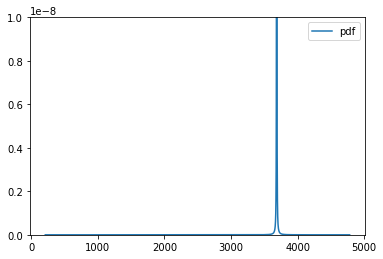

In [7]:
test_q = np.linspace(x_min, x_max, 2000000)
calcs_test = t_f(test_q)
plt.clf()
# plt.plot(x_part, calcs, '.')
plt.plot(test_q, calcs_test, label = 'pdf')
# plt.plot(test_q, res_y, label = 'res')
plt.legend()
plt.ylim(0.0, 1e-8)
# plt.yscale('log')
# plt.xlim(3080, 3110)
plt.savefig('np-test.png')
# print(jpsi_width)